In [1]:
# data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Assume, we want to identify one digit, let's say the digit is 5. So, the model needs to classify whether it is 5 or not 5. First , let's create the the target vector for this task.

In [2]:
y_train_5 = (y_train == '5') # true for all 5s, false for other digits
y_test_5 = (y_test == '5')

In [3]:
# model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [4]:
sgd_clf.predict([X_test[0]])

array([False])

In [5]:
y_test[0]

'7'

### Performance Measures
#### 1 Measuring Accuracy Using Cross-Validation

In [6]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wait, let's look at a dummy classifiers that just classifier every image in the most frequent class that is 'not-5' class.

In [7]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

This happened because only 10% images are 5, other 90% are not 5 that are correctly classified by the Dummy Classifier.
##### 2 Confusion Matrix

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

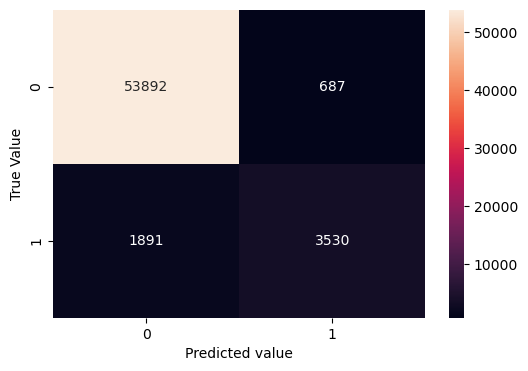

In [10]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')  # Use 'd' for regular numeric format
plt.ylabel('True Value')
plt.xlabel('Predicted value')
plt.show()

In [11]:
y_train_perfect_prediction = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5,y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### 3 Precision, Recall, and F1-Score

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision: {precision_score(y_train_5,y_train_pred)}")
print(f"Recall: {recall_score(y_train_5,y_train_pred)}")
print(f"F1-Score: {f1_score(y_train_5,y_train_pred)}")

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1-Score: 0.7325171197343846


#### 4 The Precision/Recall Trade-off

In [13]:
y_scores = sgd_clf.decision_function([X_train[10]])
y_scores

array([-5711.47789687])

In [14]:
threshold = 0
y_random_pred = (y_scores<threshold)
y_random_pred

array([ True])

In [15]:
threshold = 0
y_random_pred = (y_scores>threshold)
y_random_pred

array([False])

##### Precision-Recall Curve

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

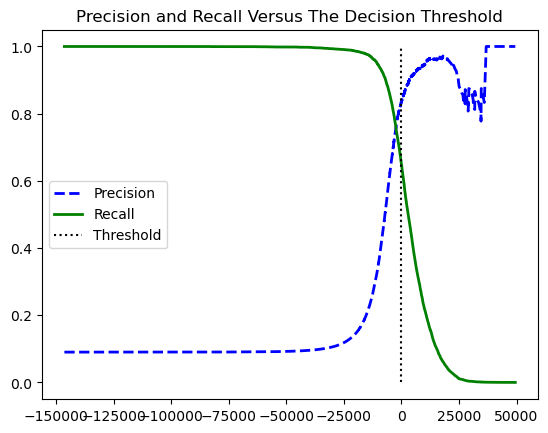

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# plotting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold")

plt.title("Precision and Recall Versus The Decision Threshold")
plt.legend()
plt.show()

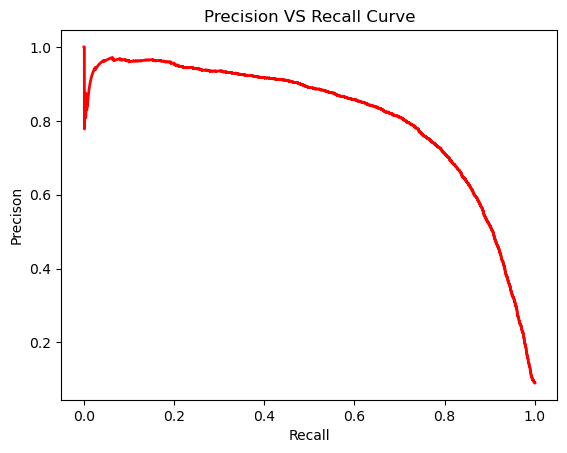

In [18]:
plt.plot(recalls,precisions, 'r-', linewidth=2, label="Precision/Recall Curve")
plt.title("Precision VS Recall Curve")
plt.ylabel("Precison")
plt.xlabel("Recall")
plt.show()

As you can see, precision starts to fall sharply at around 80% recall. Suppose, for this project we aim to use 90% precision. Let's find the threshold for that.

In [19]:
index_for_90_precision = (precisions>=0.90).argmax()
threshold_for_90_precision = thresholds[index_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [22]:
# instead of prediction, we'll have to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred_90 = (y_scores>=threshold_for_90_precision)

In [24]:
y_train_pred_90

array([False, False, False, ..., False, False, False])

#### 5 The ROC Curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

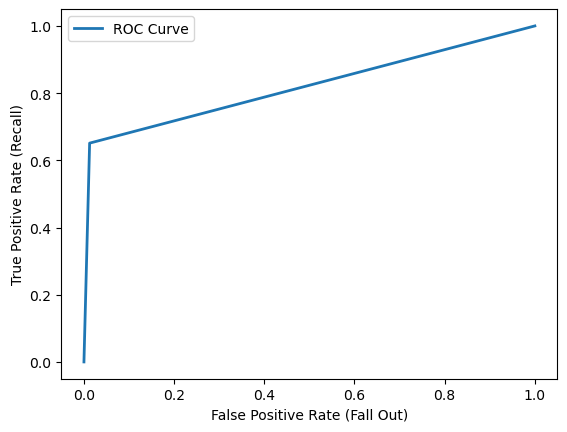

In [34]:
# plotting
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.xlabel("False Positive Rate (Fall Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()

##### Compare Classifiers: area under the curve (AUC) method
Perfect classifiers will have ROC AUC equal to 1, whereas purly random classifier will have 0.5.

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.8192920558800075

#### The RandomForest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

In [41]:
y_probas_rf = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_rf[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predict first image as positive with 89% probability ad the second image as negative with 99% probability.

In [43]:
y_score_rf = y_probas_rf[:,1]
y_score_rf

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [44]:
precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_train_5, y_score_rf)

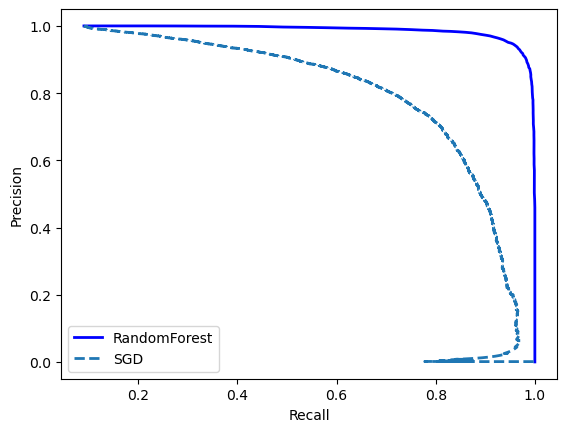

In [47]:
# plottting 
plt.plot(precision_rf, recall_rf, "b-", linewidth=2, label="RandomForest")
plt.plot(precisions, recalls, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [49]:
roc_auc_score(y_train_5, y_score_rf)

0.9983436731328145

In [51]:
y_train_pred_rf = cross_val_predict(rf_clf, X_train, y_train_5, cv=3)

print(f"Precision: {precision_score(y_train_5,y_train_pred_rf)}")
print(f"Recall: {recall_score(y_train_5,y_train_pred_rf)}")
print(f"F1-Score: {f1_score(y_train_5,y_train_pred_rf)}")

Precision: 0.9905083315756169
Recall: 0.8662608374838591
F1-Score: 0.9242275142688446
